<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sklearn
if '0.22' != sklearn.__version__[:4]:
  !pip3 install scikit-plot
  !pip install -U scikit-learn
  import os
  os.kill(os.getpid(), 9)

In [5]:
!pip3 install scikit-plot

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import os
import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn
import scikitplot as skplt
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import tensorflow.keras as keras

print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)

assert ('0.22' == sklearn.__version__[:4])

from keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)
os.environ['PYTHONHASHSEED']=str(RS)
if tf.__version__[:2] == '2.':
  tf.random.set_seed(RS)
else:
  tf.random.set_random_seed(RS)

Populating the interactive namespace from numpy and matplotlib
2.1.0-rc1
2.2.4-tf
0.22.1


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})

df_train

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704080,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196051,e33b0b1abb0038261ea9fb5213b9aad000a7686edab9e4...,30,-0.083509,7,7,2,0,0,2,1,0,1,0,91,511,0.459223,1,4,33,7,2,3,1,1,17,1,1,3,1,0,3,1,1,0,1,0,0,0,0,0,0,0
196052,ed64c2d35a57e9e8e8e5bc84f3addf5552e1691a52a75d...,104,-0.548937,11,11,2,0,0,1,1,0,0,8,5,16,-0.521242,1,0,1,5,2,5,1,1,23,1,1,12,3,0,4,1,1,0,0,0,0,0,0,0,0,0
196053,b74f63aae0b4a21b972a8a322f36e7935dbd44fe47762e...,12,0.692205,9,9,3,0,0,2,1,0,1,12,2,12,-0.101043,3,7,3,5,2,5,1,1,2,3,1,12,3,0,3,1,1,1,1,1,0,0,0,0,0,0


In [0]:
df_train.info()

(13023, 30)


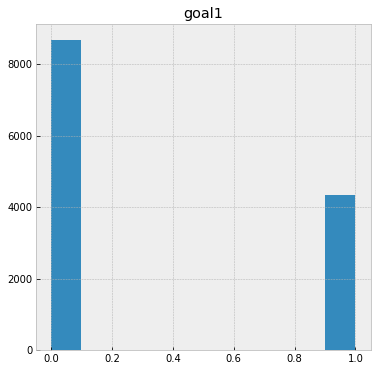

In [10]:
X, y = prepare_data( df_train, undersample=2 )
y.hist()
np.unique(y, return_counts=True)
print(X.shape)

In [0]:
def prepare_data( data, undersample=0 ):

  X = data.copy()
  y = []

  if  'goal1' in X.columns:
    y = X[['goal1']].astype(np.float32)

  FTS = list(filter(lambda x: 'field' in x, data.columns))
  X = X[FTS].astype(np.float32)

  return X, y

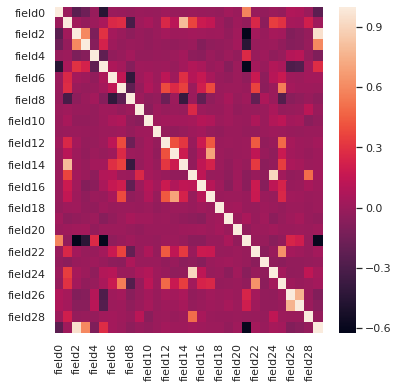

In [12]:
import seaborn as sns; sns.set()
ax = sns.heatmap(X.corr())

In [0]:
def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (18,6)

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

  plt.rcParams["figure.figsize"] = old_rcparam

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series). \
      dataset.window(window_size + 1, shift=1, drop_remainder=True). \
      dataset.flat_map(lambda window: window.batch(window_size + 1)). \
      dataset.shuffle(shuffle_buffer). \
      # dataset.map(lambda window: (window[:-1], window[-1])). \
      dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
(X.shape[0] - (X.shape[0] // (BLOCK * BS)) * BLOCK * BS)/X.shape[0] * 100

NameError: ignored

In [0]:
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 75, 30)]            0         
_________________________________________________________________
bidirectional (Bidirectional (32, 75, 122)             34038     
_________________________________________________________________
gru_1 (GRU)                  (32, 75, 61)              33855     
_________________________________________________________________
dense (Dense)                (32, 75, 1)               62        
Total params: 67,955
Trainable params: 67,955
Non-trainable params: 0
_________________________________________________________________
Train on 1952 samples, validate on 640 samples
Epoch 1/100
1952/1952 [==============================] - 5s 3ms/sample - loss: 0.1908 - auc: 0.5175 - val_loss: 0.0999 - val_auc: 0.5931
Epoch 2/100
1952/1952 [==============================] - 1s 649us/sampl

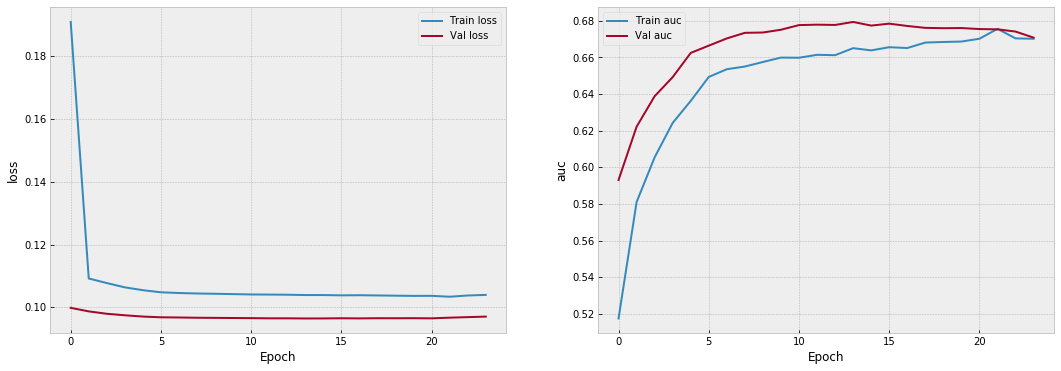

train loss: 0.67564 val loss:0.67939


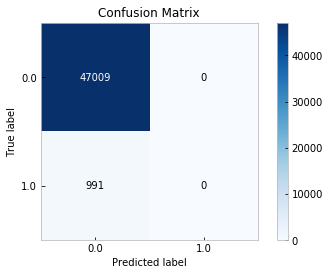

In [27]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

def create_model():
  x = inputs = Input(shape=(BLOCK, FEATURES_NUM,), batch_size=BS)
  x = Bidirectional(GRU(61, dropout=0.1, return_sequences=True, stateful=True))(x)
  x = GRU(61, return_sequences=True, stateful=True)(x)
  out = Dense(TARGET_TYPES, activation='sigmoid')(x)
  model = Model(inputs,out)

  lr=1e-3
  # optimizer=keras.optimizers.Adam(lr=lr)
  optimizer=AdamW(learning_rate=lr, weight_decay=1e-3)

  model.compile(optimizer=optimizer, 
                metrics=[tf.keras.metrics.AUC(), 
                        # 'binary_crossentropy'
                        ], 
                loss= 'binary_crossentropy'
                )

  model.reset_states()
  model.summary()

  return model

tf.keras.backend.clear_session() # goosh
RS = 86
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)
os.environ['PYTHONHASHSEED']=str(RS)
if tf.__version__[:2] == '2.':
  tf.random.set_seed(RS)
else:
  tf.random.set_random_seed(RS)

EPOCHS = 100
BS = 32
BLOCK = 75

TARGET_TYPES = 1

X, y = prepare_data( df_train )
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
FEATURES_NUM = X.shape[1]

X_train = X_train[:(X_train.shape[0] // (BLOCK * BS)) * BLOCK * BS]
y_train = y_train[:(y_train.shape[0] // (BLOCK * BS)) * BLOCK * BS]
y_cv = y_cv[:(y_cv.shape[0] // (BLOCK * BS)) * BLOCK * BS]
X_cv = X_cv[:(X_cv.shape[0] // (BLOCK * BS)) * BLOCK * BS]

center, scale = X_train.mean().values, X_train.std().values
X_train = (X_train.values - center)/scale
X_cv = (X_cv.values - center)/scale

X_train = X_train.reshape(-1, BLOCK, FEATURES_NUM)
y_train_ = y_train.values.reshape(-1, BLOCK, 1)

X_cv = X_cv.reshape(-1, BLOCK, FEATURES_NUM)
y_cv_ = y_cv.values.reshape(-1, BLOCK, 1)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

momitor = 'val_auc'
mode = 'max'
lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=1, factor=0.1, patience=7, monitor=momitor, mode=mode)
early_stop = keras.callbacks.EarlyStopping( patience=10, monitor=momitor, mode=mode )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor=momitor, save_best_only=True, mode=mode )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        model_save, 
        lr_schedule,
        reset_states
        ]

model = create_model()

history = model.fit(X_train, y_train_,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv_),
          callbacks=callbacks)

model = keras.models.load_model('my_checkpoint.h5')
model.reset_states()

plot_history(history, model.metrics_names)

# print(f'train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')
print(f'train loss: {np.max(history.history["auc"]):.5f} val loss:{np.max(history.history["val_auc"]):.5f}')

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=fig.add_subplot(1, 2, 1))
#skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=fig.add_subplot(1, 2, 2))
plt.show()

# RS=86 train loss: 0.70649 val loss:0.66916

In [197]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

tf.keras.backend.clear_session() # goosh
RS = 86 #54/1 86/1 # 88/2, 74/2, 83/100
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)
os.environ['PYTHONHASHSEED']=str(RS)
if tf.__version__[:2] == '2.':
  tf.random.set_seed(RS)
else:
  tf.random.set_random_seed(RS)

EPOCHS = 1
BS = 32
BLOCK = 200

TARGET_TYPES = 1

X, y = prepare_data( df_train )
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
FEATURES_NUM = X.shape[1]

X_train = X_train[:(X_train.shape[0] // (BLOCK * BS)) * BLOCK * BS]
y_train = y_train[:(y_train.shape[0] // (BLOCK * BS)) * BLOCK * BS]
y_cv = y_cv[:(y_cv.shape[0] // (BLOCK * BS)) * BLOCK * BS]
X_cv = X_cv[:(X_cv.shape[0] // (BLOCK * BS)) * BLOCK * BS]

center, scale = X_train.mean().values, X_train.std().values
X_train = (X_train.values - center)/scale
X_cv = (X_cv.values - center)/scale

X_train = X_train.reshape(-1, BLOCK, FEATURES_NUM)
y_train_ = y_train.values.reshape(-1, BLOCK, 1)

X_cv = X_cv.reshape(-1, BLOCK, FEATURES_NUM)
y_cv_ = y_cv.values.reshape(-1, BLOCK, 1)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

momitor = 'val_auc'
mode = 'max'
lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=1, factor=0.1, patience=7, monitor=momitor, mode=mode)
early_stop = keras.callbacks.EarlyStopping( patience=10, monitor=momitor, mode=mode )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor=momitor, save_best_only=True, mode=mode )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        #model_save, 
        lr_schedule,
        reset_states
        ]

max_auc=0
i = 0
while i<100:

  RS = i
  rn.seed(RS)
  np.random.seed(RS)
  np.random.RandomState(RS)
  os.environ['PYTHONHASHSEED']=str(RS)
  tf.random.set_seed(RS)

  del model
  model = create_model()

  history = model.fit(X_train, y_train_,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=False,
            use_multiprocessing=True,
            verbose=0,
            validation_data=(X_cv, y_cv_),
            callbacks=callbacks)
  
  val_auc = 'val_auc'
  for e in history.history:
    if val_auc in e:
      val_auc = e
  print(np.max(history.history[val_auc]))

  if np.max(history.history[val_auc]) > max_auc:
            max_auc = np.max(history.history[val_auc])
            print(i, max_auc)
  i+=1

model = keras.models.load_model('my_checkpoint.h5')
model.reset_states()

plot_history(history, model.metrics_names)

# print(f'train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')
print(f'train loss: {np.max(history.history["auc"]):.5f} val loss:{np.max(history.history["val_auc"]):.5f}')

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=fig.add_subplot(1, 2, 1))
#skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=fig.add_subplot(1, 2, 2))
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 200, 30)]           0         
_________________________________________________________________
bidirectional (Bidirectional (32, 200, 122)            34038     
_________________________________________________________________
gru_1 (GRU)                  (32, 200, 61)             33855     
_________________________________________________________________
dense (Dense)                (32, 200, 1)              62        
Total params: 67,955
Trainable params: 67,955
Non-trainable params: 0
_________________________________________________________________
0.52808416
0 0.52808416
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 200, 30)]           0         
________________

KeyboardInterrupt: ignored

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 75, 30)]            0         
_________________________________________________________________
bidirectional (Bidirectional (32, 75, 122)             34038     
_________________________________________________________________
gru_1 (GRU)                  (32, 75, 61)              33855     
_________________________________________________________________
dense (Dense)                (32, 75, 1)               62        
Total params: 67,955
Trainable params: 67,955
Non-trainable params: 0
_________________________________________________________________


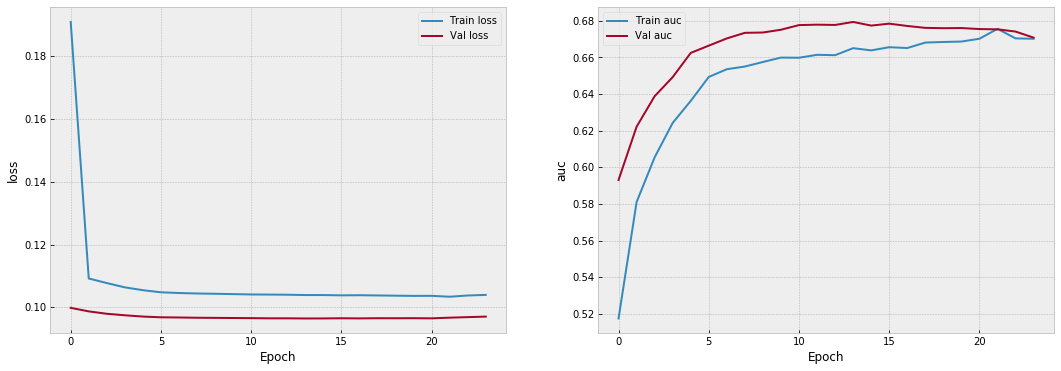

BS:32 train loss: 0.67564 val loss:0.67939


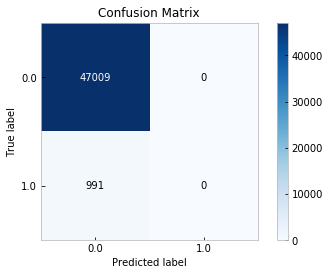

In [13]:
model = keras.models.load_model('my_checkpoint.h5')
model.reset_states()
model.summary()

plot_history(history, model.metrics_names)

print(f'BS:{BS} train loss: {np.max(history.history["auc"]):.5f} val loss:{np.max(history.history["val_auc"]):.5f}')

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=fig.add_subplot(1, 2, 1))
#skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=fig.add_subplot(1, 2, 2))
plt.show()

## Submit the result

In [0]:
X_test, _ = prepare_data( df_test )

X_test = (X_test.values - center)/scale
X = np.zeros(((X_test.shape[0] // (BLOCK * BS) + 1) * BLOCK * BS, FEATURES_NUM))
X[:X_test.shape[0]] = X_test
X_test = X.reshape(-1, BLOCK, FEATURES_NUM)

# cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
# cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
# cv_pred = cv_pred_proba.argmax(axis=1)

proba = model.predict(X_test, use_multiprocessing=True)
proba = proba.flatten()
proba = proba[:df_test.shape[0]]

pd.DataFrame(proba, columns=['proba'], index=df_test.index).to_csv('sub1.csv')

In [51]:
!zip sub1.csv.zip sub1.csv

  adding: sub1.csv (deflated 63%)


In [0]:
!pip3 install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
!pip3 install -q catboost
from catboost import CatBoostClassifier

In [0]:
!pip install -q shap

     |████████████████████████████████| 266kB 2.9MB/s 


In [0]:
!pip install -q scikit-plot
